# graph_response_time_data

Display response time data collected by `monitor_response_times_v2.py`

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
MONITORING_DATA_TIMESTAMP = "20220310_112950"
MONITORING_DATA_DIR = f"../monitoring_data_{MONITORING_DATA_TIMESTAMP}"

In [25]:
class ResponseTimeDisplayMethods:
    def __init__(self, input_filename: str, timestamp_columnname: str,
                 response_time_columname: str, graph_title: str):
        self.input_filename = input_filename
        self.timestamp_columnname = timestamp_columnname
        self.response_time_columname = response_time_columname
        self.graph_title = graph_title

    def load_file_to_df(self, sep: str = ',') -> pd.DataFrame:
        return pd.read_csv(self.input_filename, sep=sep)

    def update_timestamp_colum(self, df: pd.DataFrame) -> pd.DataFrame:
        df[self.timestamp_columnname] = pd.to_datetime(df[self.timestamp_columnname])
        df.set_index(self.timestamp_columnname)

        # Set the timestamp column as the first column
        cols = list(df)
        cols.insert(0, cols.pop(cols.index(self.timestamp_columnname)))
        df = df.loc[:, cols]
        return df

    def draw_line_graph(self, df: pd.DataFrame) -> None:

        df[self.timestamp_columnname] = pd.to_datetime(df[self.timestamp_columnname])
        df.set_index(self.timestamp_columnname)

        plt.style.use("fast")
        plt.figure(figsize=(12, 10))
        plt.xlabel("Time")
        plt.ylabel("Response Time (seconds)")
        plt.title(self.graph_title)
        plt.plot(df[self.response_time_columname])

    def display_statistics(self, df: pd.DataFrame) -> None:
        print(f"Maximum value:\t{round(df[self.response_time_columname].max(), 1)}")
        print(f"Mean value:\t\t{round(df[self.response_time_columname].mean(), 1)}")
        print(f"95th quantile:\t{round(df[self.response_time_columname].quantile(0.95), 1)}")

    def display_response_times(self) -> None:
        print(self.graph_title)
        df = self.load_file_to_df()
        df = self.update_timestamp_colum(df)
        self.display_statistics(df)
        self.draw_line_graph(df)

In [26]:
def display_martha_response_times(input_filename: str) -> None:
    graph_title = "Martha Response Time"
    timestamp_columnname = "martha.start_time"
    response_time_columname = "martha.response_duration"

    displayer = ResponseTimeDisplayMethods(input_filename, timestamp_columnname,
                                           response_time_columname, graph_title )
    displayer.display_response_times()

In [28]:
def display_fence_user_info_response_times(input_filename: str) -> None:
    graph_title = "Fence User Info Response Time"
    timestamp_columnname = "fence_user_info.start_time"
    response_time_columname = "fence_user_info.response_duration"

    displayer = ResponseTimeDisplayMethods(input_filename, timestamp_columnname,
                                           response_time_columname, graph_title )
    displayer.display_response_times()

In [31]:
def display_bond_get_link_url_response_times(input_filename: str) -> None:
    graph_title = "Bond Get Link URL Response Time"
    timestamp_columnname = "bond_get_link_url.start_time"
    response_time_columname = "bond_get_link_url.response_duration"

    displayer = ResponseTimeDisplayMethods(input_filename, timestamp_columnname,
                                           response_time_columname, graph_title )
    displayer.display_response_times()

In [33]:
def display_bond_get_link_status_response_times(input_filename: str) -> None:
    graph_title = "Bond Get Link Status Response Time"
    timestamp_columnname = "bond_get_link_status.start_time"
    response_time_columname = "bond_get_link_status.response_duration"

    displayer = ResponseTimeDisplayMethods(input_filename, timestamp_columnname,
                                           response_time_columname, graph_title )
    displayer.display_response_times()

Martha Response Time
Maximum value:	58.2
Mean value:		30.0
95th quantile:	58.1


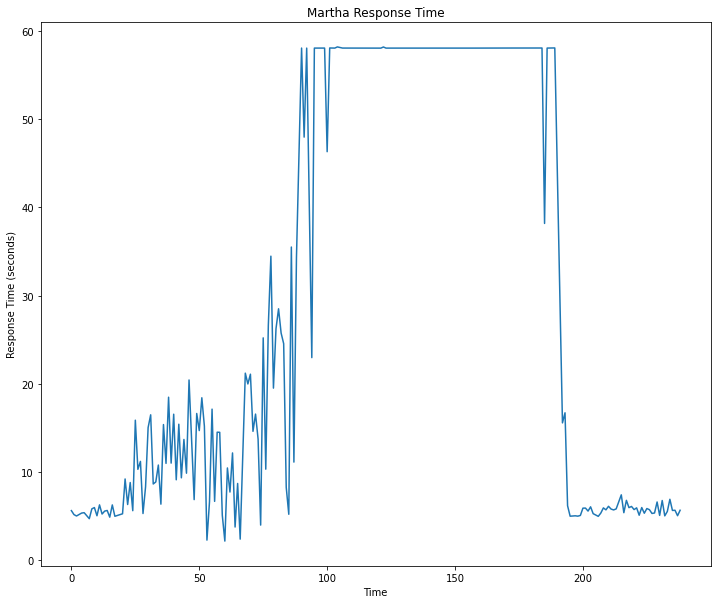

In [29]:
display_martha_response_times(f"{MONITORING_DATA_DIR}/martha_response_time_{MONITORING_DATA_TIMESTAMP}.csv")

Fence User Info Response Time
Maximum value:	36.9
Mean value:		3.3
95th quantile:	17.0


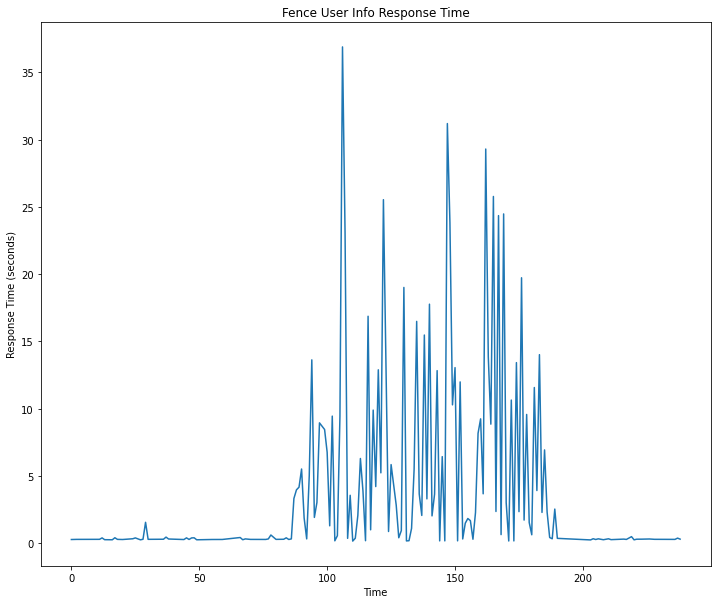

In [30]:
display_fence_user_info_response_times(f"{MONITORING_DATA_DIR}/fence_user_info_response_time_{MONITORING_DATA_TIMESTAMP}.csv")

Bond Get Link URL Response Time
Maximum value:	117.1
Mean value:		12.8
95th quantile:	57.1


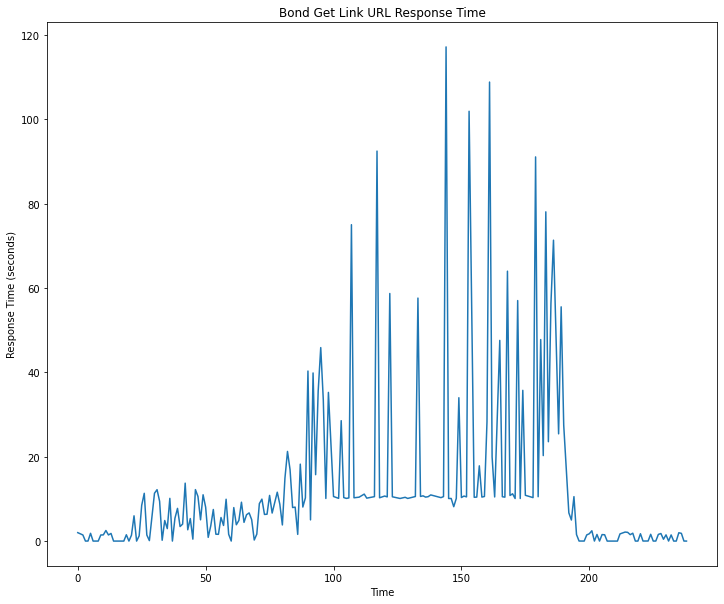

In [32]:
display_bond_get_link_url_response_times(f"{MONITORING_DATA_DIR}/bond_external_idenity_response_times_{MONITORING_DATA_TIMESTAMP}.csv")


Bond Get Link Status Response Time
Maximum value:	91.9
Mean value:		14.0
95th quantile:	54.4


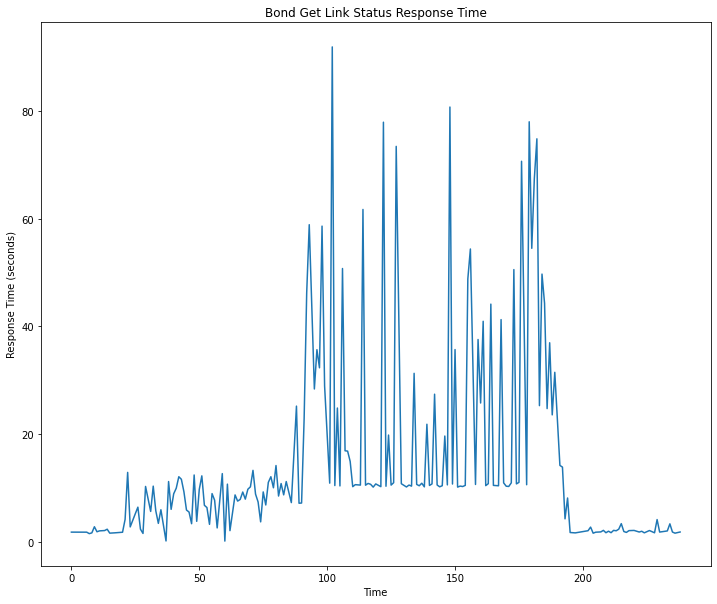

In [34]:
display_bond_get_link_status_response_times(f"{MONITORING_DATA_DIR}/bond_external_idenity_response_times_{MONITORING_DATA_TIMESTAMP}.csv")